<a href="https://colab.research.google.com/github/Tanishasharma11/Lane-detection-project/blob/main/Lanes1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
directory = '/content/NewFolder'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
import os
directory = '/content/NewFolder'
if os.path.exists(directory):
    print("Folder already exists")
else:
    os.makedirs(directory)
    print("Folder created successfully")

Folder already exists


Add test images to NewFolder by right clicking on folder / clicking on the three dots of NewFolder and selecting the upload option. Also add solidWhiteRight.jpg , solidYellowLeft.mp4 directly to content by uploading these files.

In [ ]:
#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


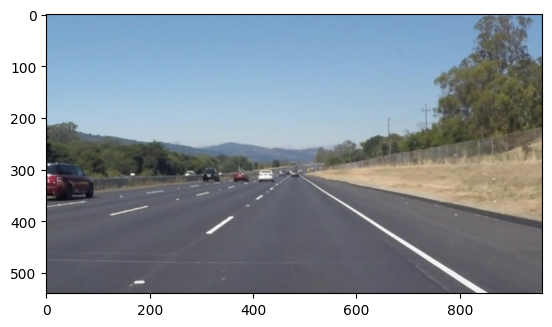

In [ ]:
#reading in an image
image = mpimg.imread('/content/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [ ]:
import math
global avgLeft
global avgRight
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def movingAverage(avg, new_sample, N=20):
    if (avg == 0):
        return new_sample
    avg -= avg / N;
    avg += new_sample / N;
    return avg;

def grayscale(img):

    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    global avgLeft
    global avgRight

    # state variables to keep track of most dominant segment
    largestLeftLineSize = 0
    largestRightLineSize = 0
    largestLeftLine = (0,0,0,0)
    largestRightLine = (0,0,0,0)

    if lines is None:
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        avgLeft = (movingAverage(avgx1, upLeftPoint[0]), movingAverage(avgy1, upLeftPoint[1]), movingAverage(avgx2, downLeftPoint[0]), movingAverage(avgy2, downLeftPoint[1]))
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return

    for line in lines:
        for x1,y1,x2,y2 in line:
            size = math.hypot(x2 - x1, y2 - y1)
            slope = ((y2-y1)/(x2-x1))
            # Filter slope based on incline and
            # find the most dominent segment based on length
            if (slope > 0.5): #right
                if (size > largestRightLineSize):
                    largestRightLine = (x1, y1, x2, y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            elif (slope < -0.5): #left
                if (size > largestLeftLineSize):
                    largestLeftLine = (x1, y1, x2, y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # Define an imaginary horizontal line in the center of the screen
    # and at the bottom of the image, to extrapolate determined segment
    imgHeight, imgWidth = (img.shape[0], img.shape[1])
    upLinePoint1 = np.array( [0, int(imgHeight - (imgHeight/3))] )
    upLinePoint2 = np.array( [int(imgWidth), int(imgHeight - (imgHeight/3))] )
    downLinePoint1 = np.array( [0, int(imgHeight)] )
    downLinePoint2 = np.array( [int(imgWidth), int(imgHeight)] )

    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p3 = np.array( [largestLeftLine[0], largestLeftLine[1]] )
    p4 = np.array( [largestLeftLine[2], largestLeftLine[3]] )
    upLeftPoint = seg_intersect(upLinePoint1,upLinePoint2, p3,p4)
    downLeftPoint = seg_intersect(downLinePoint1,downLinePoint2, p3,p4)
    if (math.isnan(upLeftPoint[0]) or math.isnan(downLeftPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upLeftPoint[0]), int(upLeftPoint[1])), (int(downLeftPoint[0]), int(downLeftPoint[1])), [0, 0, 255], 8) #draw left line

    # Calculate the average position of detected left lane over multiple video frames and draw

    avgx1, avgy1, avgx2, avgy2 = avgLeft
    avgLeft = (movingAverage(avgx1, upLeftPoint[0]), movingAverage(avgy1, upLeftPoint[1]), movingAverage(avgx2, downLeftPoint[0]), movingAverage(avgy2, downLeftPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line

    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p5 = np.array( [largestRightLine[0], largestRightLine[1]] )
    p6 = np.array( [largestRightLine[2], largestRightLine[3]] )
    upRightPoint = seg_intersect(upLinePoint1,upLinePoint2, p5,p6)
    downRightPoint = seg_intersect(downLinePoint1,downLinePoint2, p5,p6)
    if (math.isnan(upRightPoint[0]) or math.isnan(downRightPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upRightPoint[0]), int(upRightPoint[1])), (int(downRightPoint[0]), int(downRightPoint[1])), [0, 0, 255], 8) #draw left line

    # Calculate the average position of detected right lane over multiple video frames and draw

    avgx1, avgy1, avgx2, avgy2 = avgRight
    avgRight = (movingAverage(avgx1, upRightPoint[0]), movingAverage(avgy1, upRightPoint[1]), movingAverage(avgx2, downRightPoint[0]), movingAverage(avgy2, downRightPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgRight
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)


In [ ]:
import os
os.listdir("NewFolder/")

['curvy1.jpg', 'DSC02668.JPG']

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
def process_image(image):
    global avgLeft
    global avgRight

    blurredImage = gaussian_blur(image, 11)
    edgesImage = canny(blurredImage, 40, 50)
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array( [[
                [3*width/4, 3*height/5],
                [width/4, 3*height/5],
                [40, height],
                [width - 40, height]
            ]], dtype=np.int32 )

    # mask the canny output with trapezium region of interest
    regionInterestImage = region_of_interest(edgesImage, vertices)

    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 40, 30, 200)

    return weighted_img(lineMarkedImage, image)



In [ ]:
import os
directory = '/content/ResultFolder'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
import os
import matplotlib.image as mpimg
for imageName in os.listdir(inDirectory):
    imagePath = os.path.join(inDirectory, imageName)
    if os.path.isfile(imagePath):  # Skip directories
        image = mpimg.imread(imagePath)
        out = process_image(image)
        mpimg.imsave(os.path.join(outDirectory, imageName), out)
        print("Processed " + outDirectory + "/" + imageName)
print("Processing complete.")

##Incase it gives error no inDirectory or Outdirectory exists modify code by including
#inDirectory = "NewFolder"
#outDirectory="ResultFolder"
##after import matplotlib.image as mpimg

Processed ResultFolder/curvy1.jpg
Processed ResultFolder/DSC02668.JPG
Processing complete.


In [ ]:
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video yellow.mp4.
Moviepy - Writing video yellow.mp4



Moviepy - Done !
Moviepy - video ready yellow.mp4
CPU times: user 20.3 s, sys: 1.52 s, total: 21.8 s
Wall time: 1min 9s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))